In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import scipy.constants as const
from matplotlib.gridspec import GridSpec

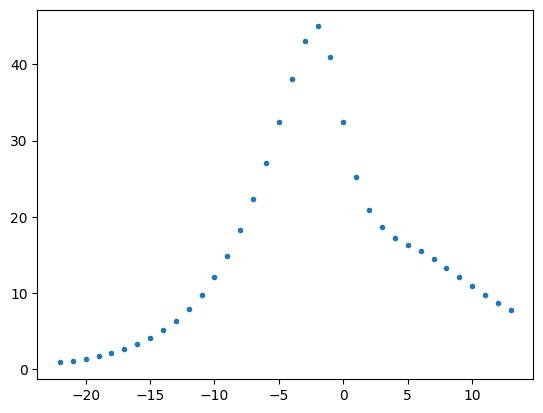

In [20]:
import numpy as np
import matplotlib.pyplot as plt

ME_data = np.load('New_Phonon_Num_Data.npy',allow_pickle=True)

b_num = ME_data.item()['b_num']
D_pows = ME_data.item()['D_pows']

plt.plot(D_pows,b_num,'.')

In [11]:
print(ME_data)
print(type(ME_data))

{'b_num': array([ 0.87243873,  1.09250289,  1.36705381,  1.70936757,  2.1359008 ,
        2.66754796,  3.32029869,  4.12974737,  5.13217172,  6.37151807,
        7.90050764,  9.78146635, 12.0863823 , 14.89520346, 18.29038475,
       22.34346504, 27.06426802, 32.44263889, 38.08568138, 43.06373257,
       44.97487741, 40.96767778, 32.45680203, 25.26568229, 20.9501124 ,
       18.63941847, 17.24877871, 16.3360079 , 15.45359532, 14.455717  ,
       13.32757235, 12.11695618, 10.8932531 ,  9.72394821,  8.66133689,
        7.73693858]), 'D_pows': array([-22., -21., -20., -19., -18., -17., -16., -15., -14., -13., -12.,
       -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,
         0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.])}
<class 'numpy.ndarray'>


In [2]:
#In units of MHz

gamma_2 = 0.425
gamma_q = 2*gamma_2
gamma_phi = gamma_2/10
kappa = 2.897

chi = -1.22

data = {}

data['gamma_q'] = gamma_q
data['gamma_phi'] = gamma_phi
data['kappa'] = kappa
data['chi'] = chi

In [3]:
exp_data = np.load('July_17_TwoTone_Data.npy', allow_pickle=True)

def S21_Norm(S,S2=[0]):
    if S2[0] == 0:
        S2 = S
    
    a = np.abs(S)
    b = np.mean(np.abs(S2[0:10]))
    c = a - b
    d = np.abs(S2) - b
    NormS21 = c / np.max(d)
    return NormS21

Freqs = exp_data.item()['freq']/1e9
Freq_zoom = exp_data.item()['freq_zoom']/1e9
Freq_wide = exp_data.item()['freq_wide']/1e9

F_mid = np.mean(Freqs)

Freqs = (Freqs - F_mid)*1000 - 5.0
Freq_wide = (Freq_wide - F_mid)*1000 -5.0
Freq_zoom = (Freq_zoom - F_mid)*1000 - 5.0

S21 = exp_data.item()['S21_nomech']
S21_wide = exp_data.item()['S21']
S21_zoom = exp_data.item()['S21_zoom']
Pow = exp_data.item()['Power']

In [4]:
def do_calc(eps_1,eps_2):

    n_ss = []
    q_ss = []
    b_ss = []
    g2 = []
    sz_ss = []
    pop_c = np.zeros((Nb,len(delta)))

    eps_q = eps_1
    eps_r = eps_2
    ii = 0
    
    for d in delta:
        d_q = d
        d_r = 0
        d_b = d + d_qb
        
        H = -0.5*(d_q)*sz
        H += (-d_r+chi)*a.dag()*a
        H += chi*sz*a.dag()*a
        
        H += -d_b*c.dag()*c
        H += eps_q*(sm + sm.dag())
        H += eps_r*(a + a.dag())
        H += g*(sm*c.dag() + sm.dag()*c)
#         H += chi*(g/gaq)*sz*(a.dag()*c + a*c.dag())

        rho_ss = steadystate(H, [c_a, c_s, c_b, c_phi])
        
        rho_phonon = ptrace(rho_ss, 2)
        pop_c[:,ii] = np.real(rho_phonon.diag())
        q_ss.append(expect(sm.dag()*sm, rho_ss))
        n_ss.append(expect(a.dag()*a, rho_ss))
        b_ss.append(expect(c.dag()*c, rho_ss))
        g2.append(expect(c.dag()*c.dag()*c*c, rho_ss)/expect(c.dag()*c, rho_ss)**2)
        ii += 1
        
    return(np.array(n_ss),np.array(q_ss),np.array(b_ss),np.array(g2),pop_c)

In [5]:
def do_calc_nomech(eps_1,eps_2):

    n_ss_1 = []
    q_ss_1 = []
    sz_ss_1 = []
    pop_c = np.zeros((N,1))

    eps_q = eps_1
    eps_r = eps_2
    ii = 0
    
    for d in delta:
        d_q = d
        d_r = 0
        d_b = d + d_qb
        
        H = -0.5*(d_q)*sz
        H += (-d_r+chi)*a.dag()*a
        H += chi*sz*a.dag()*a

        H += eps_q*(sm + sm.dag())
        H += eps_r*(a + a.dag())


        rho_ss = steadystate(H, [c_a, c_s, c_phi])
        
        if d == 0:
            rho_phonon = ptrace(rho_ss, 0)
            pop_c[:,0] = np.real(rho_phonon.diag())
        q_ss_1.append(expect(sm.dag()*sm, rho_ss))
        n_ss_1.append(expect(a.dag()*a, rho_ss))
        ii += 1
        
    return(np.array(n_ss_1),np.array(q_ss_1),pop_c)

In [7]:
N = 8

data['N'] = N
# cavity operators
a = tensor(destroy(N), identity(2))     # Readout Resonator

# Qubit operators
sm = tensor(identity(N), sigmam())
sz = tensor(identity(N), sigmaz())


c_s = np.sqrt(gamma_q) * sm
c_phi = np.sqrt(gamma_phi/2.0) * sz
c_a = np.sqrt(kappa) * a

corr = 7.5

power_db = np.array([-22.0 + corr])
eps_qs = np.sqrt(10**(power_db / 10.0))


P = power_db - corr
ng = 0.00232968*P**2 + 0.12955201*P + 2.46594372
eps_rs = np.sqrt(ng/0.476)

sigma = 0.1
delta_ab = [3.323]

gphonon  = np.array([0.162])
coop = 7.7
gama = (4/(2*coop))*gphonon**2


data['ng'] = ng
data['eps_q'] = eps_qs
data['eps_r'] = eps_rs
data['delta_ab'] = delta_ab
data['sigma'] = sigma

data['gphonon'] = gphonon
data['gamma_bs'] = gama

delta = np.linspace(-30,30,501)

data['delta_1'] = delta

n_ss_1 = np.zeros((len(gphonon),len(delta)))
q_ss_1 = np.zeros((len(gphonon),len(delta)))


# for jj,gams in enumerate(tqdm(gama)):
for ii,ep in enumerate(tqdm(gphonon)):

    d_qb = delta_ab[0]
    n_ss_1[ii,:], q_ss_1[ii,:], pop_a = do_calc_nomech(eps_qs[0],eps_rs[0])

    
data['n_ss_1'] = n_ss_1
data['q_ss_1'] = q_ss_1
data['pop_a'] = pop_a

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
Nb = 8

data['Nb'] = Nb
# cavity operators
a = tensor(destroy(N), identity(2), identity(Nb))     # Readout Resonator
c = tensor(identity(N), identity(2), destroy(Nb))     # Phonon Mode

# Qubit operators
sm = tensor(identity(N), sigmam(), identity(Nb))
sz = tensor(identity(N), sigmaz(), identity(Nb))

c_s = np.sqrt(gamma_q) * sm
c_phi = np.sqrt(gamma_phi/2.0) * sz
c_a = np.sqrt(kappa) * a

delta = np.linspace(-delta_ab[0]-sigma, -delta_ab[0]+sigma,61)
# delta = [-delta_ab[0]]
data['delta'] = delta

n_ss = np.zeros((len(gphonon),len(delta)))
q_ss = np.zeros((len(gphonon),len(delta)))
b_ss = np.zeros((len(gphonon),len(delta)))
g2_ss = np.zeros((len(gphonon),len(delta)))
pop_c = np.zeros((len(gphonon),Nb,len(delta)))

# for jj,gams in enumerate(tqdm(gama)):
for ii,gs in enumerate(tqdm(gphonon)):

    gamma_b = gama[ii]
    g = gs
    c_b = np.sqrt(gamma_b) * c
    d_qb = delta_ab[0]

    n_ss[ii,:], q_ss[ii,:], b_ss[ii,:], g2_ss[ii,:], pop_c[ii,:,:] = do_calc(eps_qs[0],eps_rs[0])


data['n_ss'] = n_ss
data['q_ss'] = q_ss
data['b_ss'] = b_ss
data['g2_ss'] = g2_ss
data['pop_c'] = pop_c

  0%|          | 0/1 [00:00<?, ?it/s]

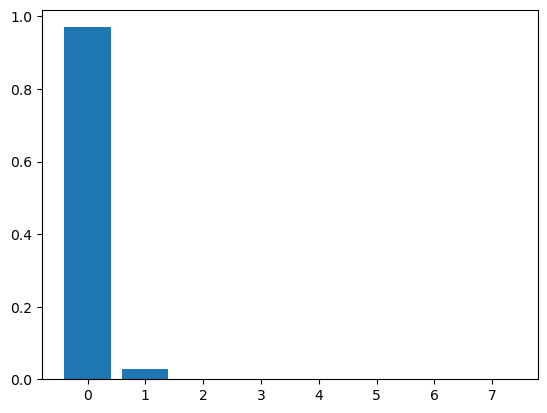

In [9]:
# for jj,gams in enumerate(gama):
for ii,gs in enumerate(gphonon):
    plt.bar(np.arange(0, Nb),pop_c[ii,:,0])

In [10]:
# np.save("August04_newqubit_minus6", data)

In [11]:
delta

array([-3.423     , -3.41966667, -3.41633333, -3.413     , -3.40966667,
       -3.40633333, -3.403     , -3.39966667, -3.39633333, -3.393     ,
       -3.38966667, -3.38633333, -3.383     , -3.37966667, -3.37633333,
       -3.373     , -3.36966667, -3.36633333, -3.363     , -3.35966667,
       -3.35633333, -3.353     , -3.34966667, -3.34633333, -3.343     ,
       -3.33966667, -3.33633333, -3.333     , -3.32966667, -3.32633333,
       -3.323     , -3.31966667, -3.31633333, -3.313     , -3.30966667,
       -3.30633333, -3.303     , -3.29966667, -3.29633333, -3.293     ,
       -3.28966667, -3.28633333, -3.283     , -3.27966667, -3.27633333,
       -3.273     , -3.26966667, -3.26633333, -3.263     , -3.25966667,
       -3.25633333, -3.253     , -3.24966667, -3.24633333, -3.243     ,
       -3.23966667, -3.23633333, -3.233     , -3.22966667, -3.22633333,
       -3.223     ])

In [12]:
Pow[0]

-22.0

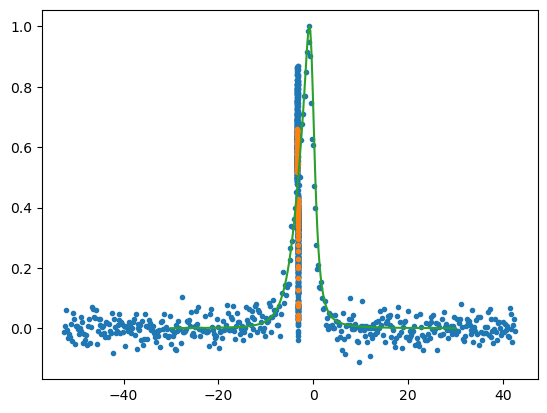

In [13]:
mm = 0
nn = 0

delta_1 = np.linspace(-30,30,501)
# delta = np.linspace(-delta_ab[0]-sigma, -delta_ab[0]+sigma,3)

plt.plot(Freq_wide,S21_Norm(S21_wide[mm],S21[mm]),'.')
plt.plot(delta, q_ss[nn,:]/np.max(q_ss_1[nn]), '.')
plt.plot(delta_1,q_ss_1[nn,:]/np.max(q_ss_1[nn]))

# plt.xlim([-4,-3.5])

(-3.45, -3.2)

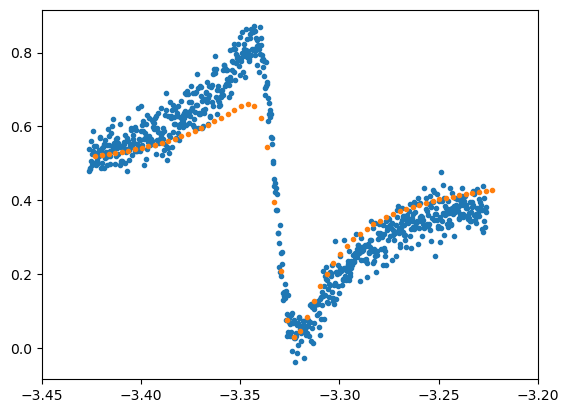

In [15]:
plt.plot(Freq_zoom,S21_Norm(S21_zoom[mm],S21[mm]),'.')
# plt.plot(delta_1, q_ss_1[nn,:]/np.max(q_ss_1[nn]))
plt.plot(delta, q_ss[nn,:]/np.max(q_ss_1[nn]), '.')

plt.xlim([-3.45,-3.2])


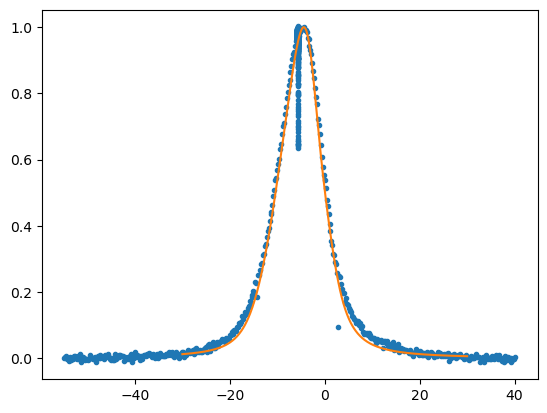

In [42]:
mm = 19
nn = 0

delta_1 = np.linspace(-30,30,501)
delta = np.linspace(-delta_ab[0]-sigma, -delta_ab[0]+sigma,3)

plt.plot(Freq_wide-2.4,S21_Norm(S21_wide[mm],S21[mm]),'.')
# plt.plot(delta, q_ss[nn,:]/np.max(q_ss_1[nn]), '.')
plt.plot(delta_1,q_ss_1[nn,:]/np.max(q_ss_1[nn]))

# plt.xlim([-4,-3.5])

(0.6, 1.05)

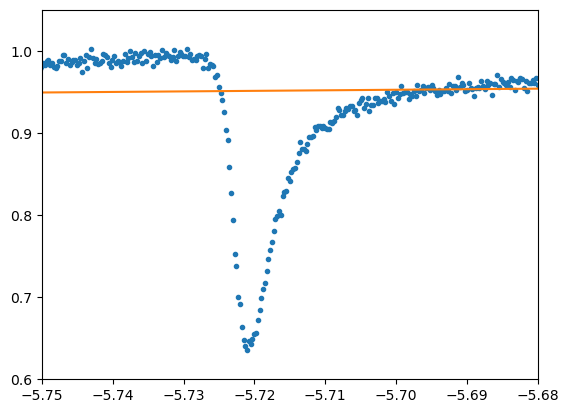

In [43]:
plt.plot(Freq_zoom-2.40,S21_Norm(S21_zoom[mm],S21[mm]),'.')
plt.plot(delta_1, q_ss_1[nn,:]/np.max(q_ss_1[nn]))

plt.xlim([-5.75,-5.68])
plt.ylim(0.6,1.05)